# **Ecuación de Onda**

---
Entrenamiento de un modelo FNO para la Ecuación de Onda. Se probará también el desempeño del modelo al ser evaluado en una resolución mayor a la cual fue entrenado.

In [1]:
# Importar librerías
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib import animation
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from neuralop.losses.finite_diff import central_diff_2d
from neuralop.data.datasets.pt_dataset import PTDataset

from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## **Carga de Datos y Definición del Modelo**

In [2]:
dataset = PTDataset(
    root_dir="../data/wave_data",
    dataset_name="onda",
    n_train=1024,
    n_tests=[192, 192, 192],
    batch_size=32,
    test_batch_sizes=[32, 32, 32],
    train_resolution=64,
    test_resolutions=[32, 64, 128],
    channel_dim=1
)

train_loader = DataLoader(dataset.train_db, batch_size=32, shuffle=True)
test_loaders = {res: DataLoader(db, batch_size=32, shuffle=False) for res, db in dataset.test_dbs.items()}
data_processor = dataset.data_processor.to(device)


print("Train dataset size:", len(dataset.train_db))
print("Test datasets sizes:", {res: len(db) for res, db in dataset.test_dbs.items()})


Loading test db for resolution 32 with 192 samples 
Loading test db for resolution 64 with 192 samples 
Loading test db for resolution 128 with 192 samples 
Train dataset size: 1024
Test datasets sizes: {32: 192, 64: 192, 128: 192}


In [3]:
# Definición del Modelo
model = FNO(n_modes=(48,48),
            in_channels=1, 
            out_channels=1,
            hidden_channels=32, 
            projection_channel_ratio=2)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nThe Model has {n_params} parameters.')
sys.stdout.flush()


The Model has 9843553 parameters.


In [4]:
# Definición del Optimizador
optimizer = AdamW(model.parameters(), 
                  lr=8e-3, 
                  weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max=30)

In [5]:
# Definir las Funciones Pérdida
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [6]:
# Resumen del Modelo
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 48, 25]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64,

## **Entrenamiento**

In [7]:
trainer = Trainer(model=model, 
                  n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=4,
                  use_distributed=False,
                  verbose=True)

In [8]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1024 samples
Testing on [192, 192, 192] samples         on resolutions [32, 64, 128].
Raw outputs of shape torch.Size([32, 1, 64, 64])
[0] time=32.85, avg_loss=0.3646, train_err=11.6663
Eval: 32_h1=1.2791, 32_l2=1.1224, 64_h1=0.0703, 64_l2=0.2135, 128_h1=1.1129, 128_l2=0.7889
[4] time=36.45, avg_loss=0.0435, train_err=1.3935
Eval: 32_h1=1.2434, 32_l2=1.0603, 64_h1=0.0274, 64_l2=0.1073, 128_h1=1.0904, 128_l2=0.7498
[8] time=31.26, avg_loss=0.0327, train_err=1.0452
Eval: 32_h1=1.2440, 32_l2=1.0571, 64_h1=0.0320, 64_l2=0.0881, 128_h1=1.0880, 128_l2=0.7464
[12] time=31.04, avg_loss=0.0232, train_err=0.7434
Eval: 32_h1=1.2457, 32_l2=1.0577, 64_h1=0.0210, 64_l2=0.0666, 128_h1=1.0917, 128_l2=0.7467
[16] time=29.07, avg_loss=0.0157, train_err=0.5008
Eval: 32_h1=1.2483, 32_l2=1.0582, 64_h1=0.0172, 64_l2=0.0458, 128_h1=1.0936, 128_l2=0.7467


{'train_err': 0.3331302613951266,
 'avg_loss': 0.010410320668597706,
 'avg_lasso_loss': None,
 'epoch_train_time': 29.859756099998776}

## **Visualización**

Para ver una comparación entre las soluciones reales y las obtenidas con el modelo se usa el siguiente código. Primero se seleccionan tres índices aleatorios para los cuales se presenta la condición incial, el *ground_truth* (solución real) y el output de la red (predicción).

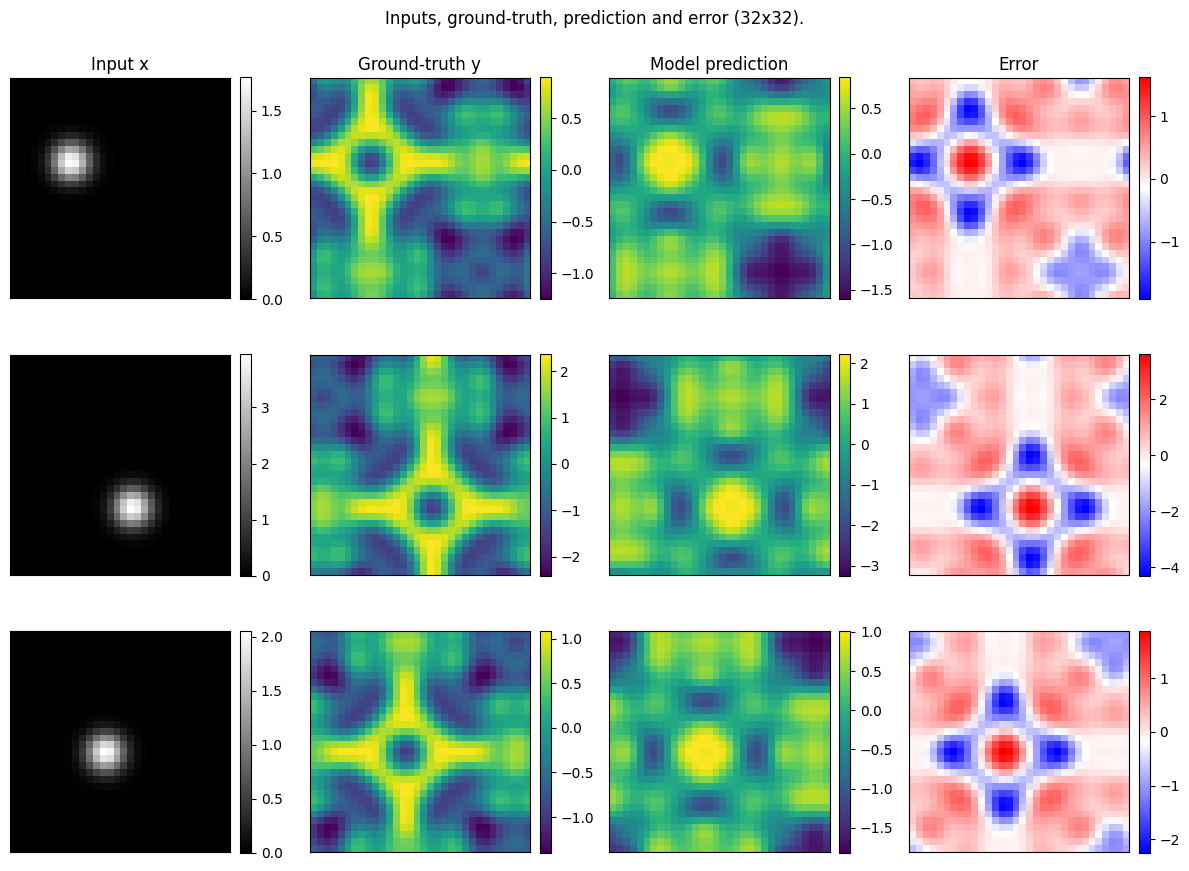

In [11]:
test_samples = test_loaders[32].dataset

selected_indices = np.random.randint(0, len(test_samples), size=3)
fig = plt.figure(figsize=(12, 9))

for plot_idx, index in enumerate(selected_indices):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x']
    y = data['y']
    out = model(x.unsqueeze(0)).squeeze().detach().numpy() 
    gt = y.squeeze().numpy()

    error = out - gt

    # Columna 1: Input
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 1)
    im0 = ax.imshow(x[0], cmap='gray')
    if plot_idx == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)

    # Columna 2: Ground-truth
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 2)
    im1 = ax.imshow(gt)
    if plot_idx == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

    # Columna 3: Predicción
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 3)
    im2 = ax.imshow(out)
    if plot_idx == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

    # Columna 4: Error (predicción - ground truth)
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 4)
    im3 = ax.imshow(error, cmap='bwr')
    if plot_idx == 0:
        ax.set_title('Error')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im3, ax=ax, fraction=0.046, pad=0.04)

fig.suptitle('Inputs, ground-truth, prediction and error (32x32).', y=0.98)
plt.tight_layout()
plt.show()

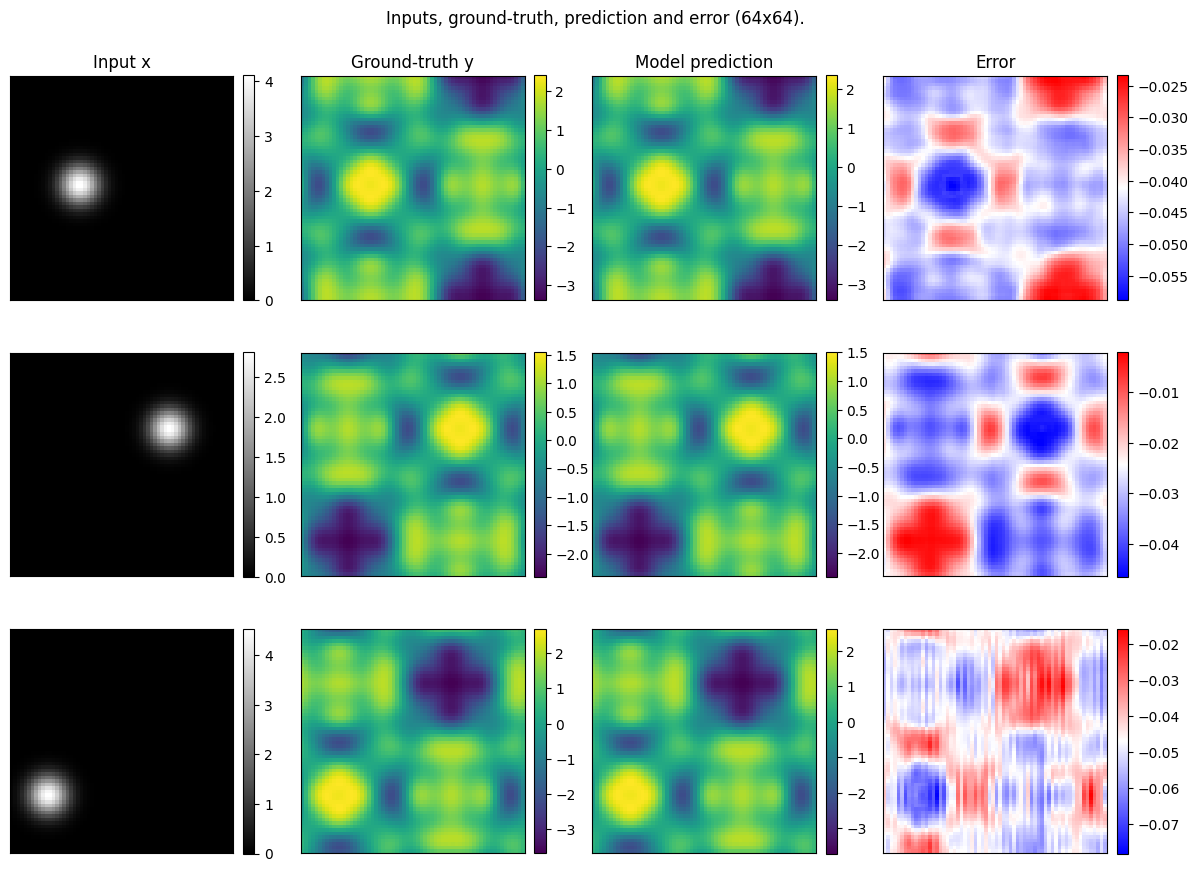

In [12]:
test_samples = test_loaders[64].dataset

selected_indices = np.random.randint(0, len(test_samples), size=3)
fig = plt.figure(figsize=(12, 9))

for plot_idx, index in enumerate(selected_indices):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x']
    y = data['y']
    out = model(x.unsqueeze(0)).squeeze().detach().numpy() 
    gt = y.squeeze().numpy()

    error = out - gt

    # Columna 1: Input
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 1)
    im0 = ax.imshow(x[0], cmap='gray')
    if plot_idx == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)

    # Columna 2: Ground-truth
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 2)
    im1 = ax.imshow(gt)
    if plot_idx == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

    # Columna 3: Predicción
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 3)
    im2 = ax.imshow(out)
    if plot_idx == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

    # Columna 4: Error (predicción - ground truth)
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 4)
    im3 = ax.imshow(error, cmap='bwr')
    if plot_idx == 0:
        ax.set_title('Error')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im3, ax=ax, fraction=0.046, pad=0.04)

fig.suptitle('Inputs, ground-truth, prediction and error (64x64).', y=0.98)
plt.tight_layout()
plt.show()


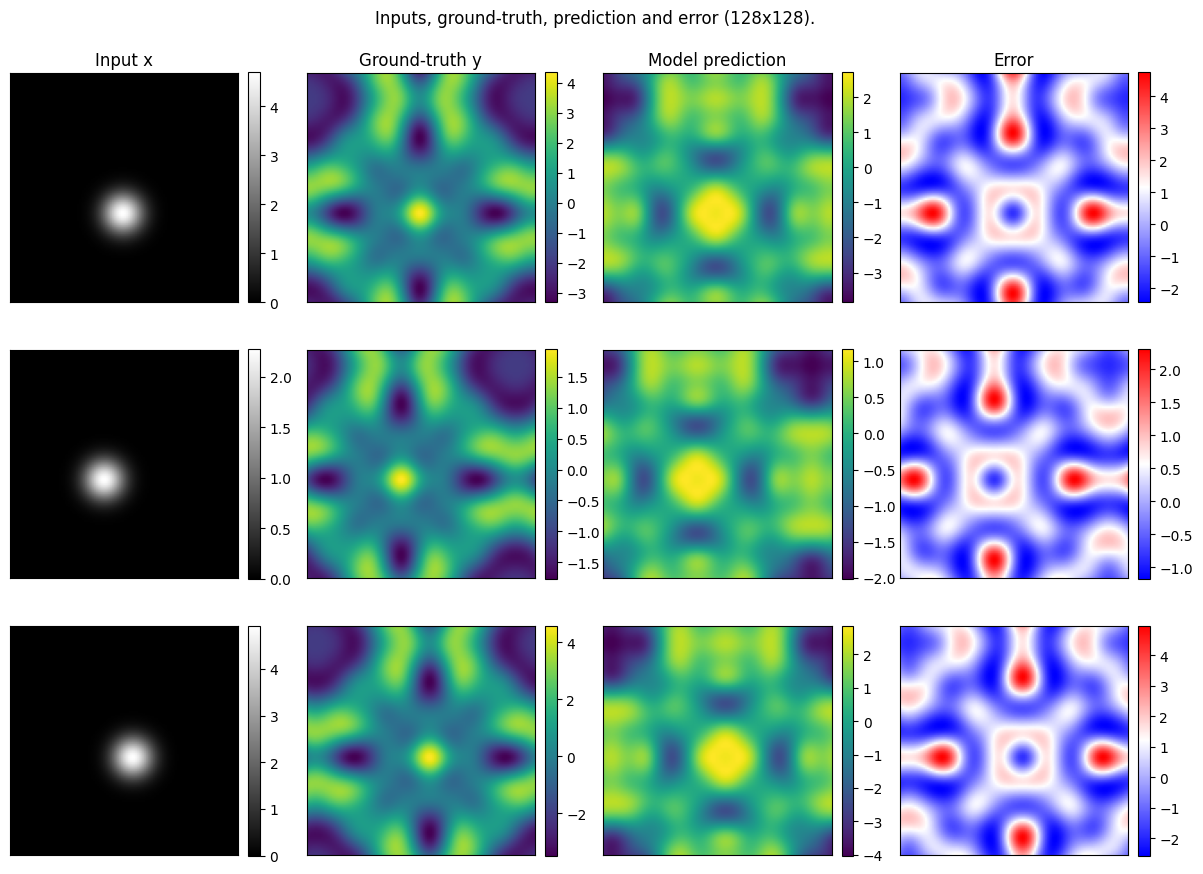

In [13]:
test_samples = test_loaders[128].dataset

selected_indices = np.random.randint(0, len(test_samples), size=3)
fig = plt.figure(figsize=(12, 9))

for plot_idx, index in enumerate(selected_indices):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x']
    y = data['y']
    out = model(x.unsqueeze(0)).squeeze().detach().numpy() 
    gt = y.squeeze().numpy()

    error = out - gt

    # Columna 1: Input
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 1)
    im0 = ax.imshow(x[0], cmap='gray')
    if plot_idx == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)

    # Columna 2: Ground-truth
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 2)
    im1 = ax.imshow(gt)
    if plot_idx == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

    # Columna 3: Predicción
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 3)
    im2 = ax.imshow(out)
    if plot_idx == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

    # Columna 4: Error (predicción - ground truth)
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 4)
    im3 = ax.imshow(error, cmap='bwr')
    if plot_idx == 0:
        ax.set_title('Error')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im3, ax=ax, fraction=0.046, pad=0.04)

fig.suptitle('Inputs, ground-truth, prediction and error (128x128).', y=0.98)
plt.tight_layout()
plt.show()